In [3]:
!pip install datasets

  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/60/bf/cea0b9720c32fa01b0c4ec4b16b9f4ae34ca106b202ebbae9f03ab98cd8f/huggingface_hub-0.26.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 1.0 MB/s eta 0:00:00ta 0:00:01


In [4]:
from datasets import load_dataset

ds = load_dataset("naver-clova-ix/cord-v2")

import os
import json
import shutil
from PIL import Image

def convert_cord_to_ufo(ds_split, split_name):
    formatted_data = {"images": {}}
    
    for idx, item in enumerate(ds_split):
        # 이미지 ID를 split에 따라 다르게 생성
        image_id = f"receipt_{split_name}_{idx:04d}.jpg"
        gt_data = json.loads(item['ground_truth'])
        
        # 기본 이미지 정보 설정
        image_data = {
            "paragraphs": {},
            "words": {},
            "chars": {},
            "img_w": gt_data['meta']['image_size']['width'],
            "img_h": gt_data['meta']['image_size']['height'],
            "num_patches": None,
            "tags": [],
            "relations": {},
            "annotation_log": {
                "worker": "worker",
                "timestamp": "2024-05-30",
                "tool_version": "",
                "source": None
            },
            "license_tag": {
                "usability": True,
                "public": False,
                "commercial": True,
                "type": None,
                "holder": "CORD"
            },
            "img_path": ""
        }
        
        # valid_line에서 단어 정보 추출
        word_count = 1
        for line in gt_data['valid_line']:
            for word in line['words']:
                word_id = f"{word_count:04d}"
                word_count += 1
                
                quad = word['quad']
                points = [
                    [quad['x1'], quad['y1']],
                    [quad['x2'], quad['y2']],
                    [quad['x3'], quad['y3']],
                    [quad['x4'], quad['y4']]
                ]
                
                category = line['category'].split('.')[0]
                
                word_data = {
                    "transcription": word['text'],
                    "points": points,
                    "orientation": "Horizontal",
                    "language": None,
                    "tags": [],
                    "confidence": 1.0,
                    "illegibility": False
                }
                
                image_data['words'][word_id] = word_data
        
        formatted_data['images'][image_id] = image_data
    
    return formatted_data

# 디렉토리 생성
base_dir = '/data/ephemeral/home/code/data/other_receipt'
os.makedirs(os.path.join(base_dir, 'img/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'img/test'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'ufo'), exist_ok=True)

# train 데이터 처리
train_data = convert_cord_to_ufo(ds['train'], 'train')
for idx, img in enumerate(ds['train']['image']):
    img_filename = f'receipt_train_{idx:04d}.jpg'
    img_path = os.path.join(base_dir, 'img/train', img_filename)
    img.save(img_path)
    train_data['images'][img_filename]['img_path'] = f'train/{img_filename}'
    
    '''태그 추가 코드'''
    train_data['images'][img_filename]['tags'].append('external data')

# validation 데이터 처리
val_data = convert_cord_to_ufo(ds['validation'], 'val')
for idx, img in enumerate(ds['validation']['image']):
    img_filename = f'receipt_val_{idx:04d}.jpg'
    img_path = os.path.join(base_dir, 'img/train', img_filename)
    img.save(img_path)
    val_data['images'][img_filename]['img_path'] = f'train/{img_filename}'
    
    '''태그 추가 코드'''
    val_data['images'][img_filename]['tags'].append('external data')

# test 데이터 처리
test_data = convert_cord_to_ufo(ds['test'], 'test')
for idx, img in enumerate(ds['test']['image']):
    img_filename = f'receipt_test_{idx:04d}.jpg'
    img_path = os.path.join(base_dir, 'img/test', img_filename)
    img.save(img_path)
    test_data['images'][img_filename]['img_path'] = f'test/{img_filename}'

# UFO 데이터셋을 JSON 파일로 저장
with open(os.path.join(base_dir, 'ufo/train_random.json'), 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

with open(os.path.join(base_dir, 'ufo/val_random.json'), 'w', encoding='utf-8') as f:
    json.dump(val_data, f, ensure_ascii=False, indent=2)

with open(os.path.join(base_dir, 'ufo/test.json'), 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=2)

print("이미지와 UFO 데이터셋이 성공적으로 저장되었습니다.")

이미지와 UFO 데이터셋이 성공적으로 저장되었습니다.


# 변환이 잘 됬는지 결과 확인

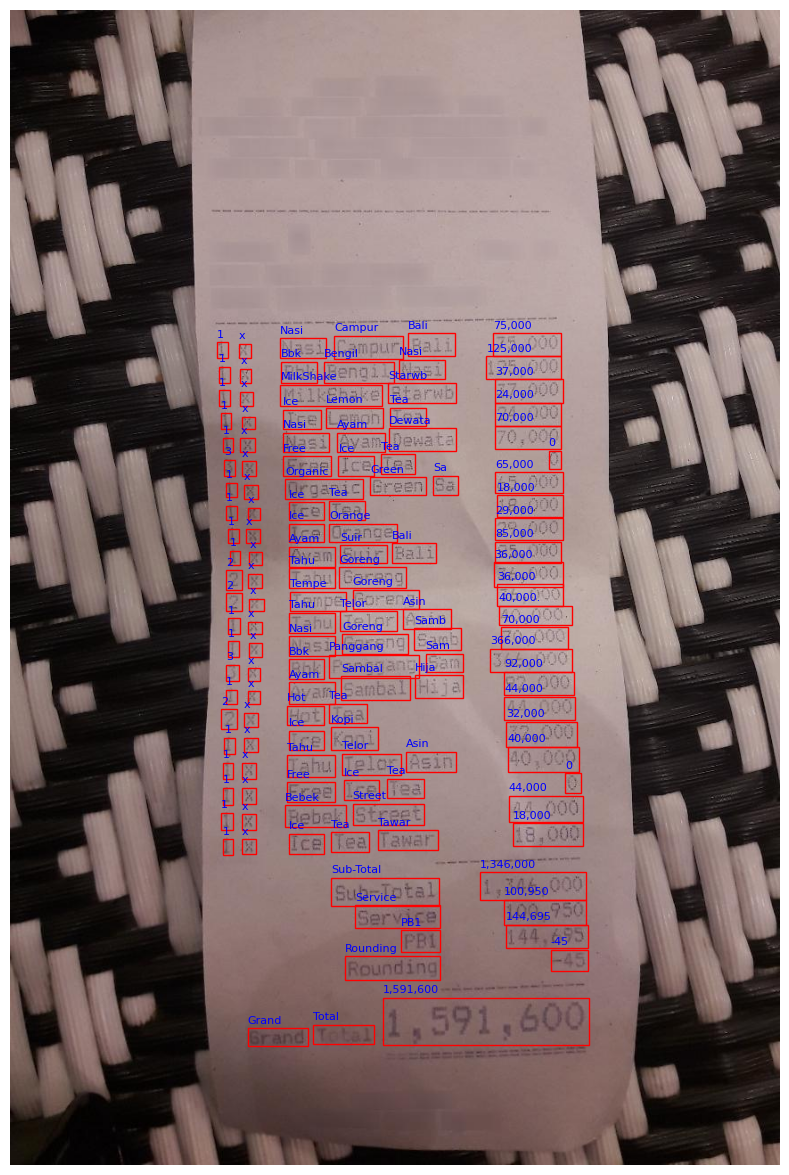

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import json

base_dir = '/data/ephemeral/home/code/data/other_receipt'

def visualize_boxes(img_path, json_data, img_name):
    # 이미지 로드
    img = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(15, 15))
    ax.imshow(img)
    
    # 해당 이미지의 words 정보 가져오기
    words = json_data['images'][img_name]['words']
    
    # 각 단어의 bounding box 그리기
    for word_info in words.values():
        points = word_info['points']
        # 좌표 추출
        x_min = min(p[0] for p in points)
        y_min = min(p[1] for p in points)
        width = max(p[0] for p in points) - x_min
        height = max(p[1] for p in points) - y_min
        
        # 박스 그리기
        rect = patches.Rectangle((x_min, y_min), width, height, 
                               linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # 텍스트 추가
        plt.text(x_min, y_min-5, word_info['transcription'], 
                color='blue', fontsize=8)
    
    plt.axis('off')
    plt.show()

# train 데이터셋에서 첫 번째 이미지 시각화 예시
with open(os.path.join(base_dir, 'ufo/train_random.json'), 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# 첫 번째 이미지 파일명 가져오기
first_img_name = list(train_data['images'].keys())[0]
img_path = os.path.join(base_dir, 'img', train_data['images'][first_img_name]['img_path'])

# 시각화
visualize_boxes(img_path, train_data, first_img_name)
